In [ ]:
%pip install --upgrade scikeras

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.metrics import r2_score as AjusteR2
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier,KerasRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import Dense, LSTM, Dropout
from sklearn.base import BaseEstimator,ClassifierMixin
import warnings; warnings.filterwarnings('ignore')

In [ ]:
#@title **Clonando github**
!git clone https://github.com/DenilsonUFPA/ENIAC-2024.git

In [3]:
dados = pd.read_csv('/content/ENIAC-2024/Dados/Não Linear - RNN - PRMLS/PRMLS03.csv', sep=',',header=None).to_numpy().T
np.shape(dados)

(4804, 3)

In [4]:
# dados = pd.read_csv('coleta_multinivel_01.csv', sep=',').to_numpy()

t = dados[:,0]
u = dados[:,1]
y = dados[:,2]

In [18]:
def Norma(u, y):
  u = u.reshape(-1, 1)
  y = y.reshape(-1, 1)

  scaler = MinMaxScaler()

  u_norm = scaler.fit_transform(u)
  y_norm = scaler.fit_transform(y)

  u_unno = scaler.inverse_transform(u_norm)
  y_unno = scaler.inverse_transform(y_norm)

  u_norm = u_norm.flatten()
  y_norm = y_norm.flatten()
  u_unno = u.flatten()
  y_unno = y.flatten()

  return  u_norm, y_norm, u_unno, y_unno

In [ ]:
#@title **Resposta Sinal PRMLS: Ensaio 03 - Não Normalizado**
# plt.figure(figsize=(12,10))
# plt.subplot(211)
# plt.title('Resposta ao Sinal PRMLS: Ensaio 03')
# plt.rcParams['font.size'] = 14
# plt.plot(t, u,'r',label = 'u')
# plt.ylabel("$u(t)$ $(v)$")
# plt.xlabel("$Tempo$ $(s)$")
# plt.grid()
# plt.legend()
# plt.subplot(212)
# plt.rcParams['font.size'] = 14
# plt.plot(t, y,'b',label = 'y')
# plt.ylabel("$y(t)$ $(v)$")
# plt.xlabel("$Tempo$ $(s)$")
# plt.grid()
# plt.legend()
# # plt.savefig('Dados originais.png')
# plt.show()

In [ ]:
# u_norm, y_norm, u, y = Norma(u, y)

In [ ]:
#@title **Resposta Sinal PRMLS: Ensaio 03 - Normalizado**
# plt.figure(figsize=(12,10))
# plt.subplot(211)
# plt.title('Resposta ao Sinal PRMLS: Ensaio 03')
# plt.rcParams['font.size'] = 14
# plt.plot(t, u_norm,'r',label = 'u')
# plt.ylabel("$u(t)$ $(v)$")
# plt.xlabel("$Tempo$ $(s)$")
# plt.grid()
# plt.legend()
# plt.subplot(212)
# plt.rcParams['font.size'] = 14
# plt.plot(t, y_norm,'b',label = 'y')
# plt.ylabel("$y(t)$ $(v)$")
# plt.xlabel("$Tempo$ $(s)$")
# plt.grid()
# plt.legend()
# # plt.savefig('Dados originais.png')
# plt.show()

In [ ]:
#@title **Resposta Sinal PRMLS: Ensaio 03 - Não Normalizado**
plt.figure(figsize=(12,10))
plt.subplot(211)
plt.title('Resposta ao Sinal PRMLS: Ensaio 03')
plt.rcParams['font.size'] = 14
plt.plot(t, u,'r',label = 'u')
plt.ylabel("$u(t)$ $(v)$")
plt.xlabel("$Tempo$ $(s)$")
plt.grid()
plt.legend()
plt.subplot(212)
plt.rcParams['font.size'] = 14
plt.plot(t, y,'b',label = 'y')
plt.ylabel("$y(t)$ $(v)$")
plt.xlabel("$Tempo$ $(s)$")
plt.grid()
plt.legend()
# plt.savefig('Dados originais.png')
plt.show()

In [5]:
Xs = np.array([u,y]).T
Ys = np.array([y]).T

# Xs = np.array([u_norm,y_norm]).T
# Ys = np.array([y_norm]).T


In [6]:

percIdent = 0.6
Ns = len(u)       # Percentual de amostras de identificação
Ni = int(Ns*percIdent)  # Número de amostras identificação

Xs_train = Xs[0:Ni]
Ys_train = Ys[0:Ni]

Xs_val = Xs[Ni:]
Ys_val = Ys[Ni:]

Xs_train.shape, Ys_train.shape, Xs_val.shape, Ys_val.shape

((2882, 2), (2882, 1), (1922, 2), (1922, 1))

In [7]:
Nsi = 5
X_train = []
Y_train = []
for i in np.arange(Nsi,len(Xs_train)):
    X_train.append(Xs_train[i-Nsi:i,:])
    Y_train.append(Ys_train[i])

X_val = []
Y_val = []
for i in np.arange(Nsi,len(Xs_val)):
    X_val.append(Xs_val[i-Nsi:i,:])
    Y_val.append(Ys_val[i])

X_train, Y_train = np.array(X_train), np.array(Y_train)
X_val, Y_val = np.array(X_val), np.array(Y_val)


In [8]:
def creat_model():
  model = Sequential()
  model.add(LSTM(units=100, return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
  model.add(Dropout(0.2))
  model.add(LSTM(units=100, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=100))
  model.add(Dropout(0.2))
  model.add(Dense(units=Y_train.shape[1])) #units = number of outputs
  model.compile(optimizer = 'adam', loss = 'mse', metrics=['r2_score'])
  # Parada antecipada:
  es = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

  return model

In [9]:
model_kerasRegressor = KerasRegressor(build_fn=creat_model, verbose=2, loss='mse',metrics=['r2_score'])
model_kerasRegressor

KerasRegressor(
	model=None
	build_fn=<function creat_model at 0x79c1b3e8c310>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=mse
	metrics=['r2_score']
	batch_size=None
	validation_batch_size=None
	verbose=2
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
)

In [10]:
model_kerasRegressor.get_params().keys()

dict_keys(['model', 'build_fn', 'warm_start', 'random_state', 'optimizer', 'loss', 'metrics', 'batch_size', 'validation_batch_size', 'verbose', 'callbacks', 'validation_split', 'shuffle', 'run_eagerly', 'epochs'])

In [12]:
params={
        'batch_size':[1,2],
        'epochs':[1,2]
       }

In [13]:
grid = GridSearchCV(estimator=model_kerasRegressor, param_grid=params, cv=3, verbose=2)
grid

GridSearchCV(cv=3,
             estimator=KerasRegressor(build_fn=<function creat_model at 0x79c1b3e8c310>, loss='mse', metrics=['r2_score'], verbose=2),
             param_grid={'batch_size': [1, 2], 'epochs': [1, 2]}, verbose=2)

In [14]:
grid_result = grid.fit(X_val, Y_val, verbose=2, validation_data=(X_train, Y_train))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
1278/1278 - 43s - 34ms/step - loss: 0.2104 - r2_score: 0.8172 - val_loss: 0.0340 - val_r2_score: 0.9772
639/639 - 6s - 9ms/step
[CV] END .............................batch_size=1, epochs=1; total time=  54.4s
1278/1278 - 43s - 34ms/step - loss: 0.2276 - r2_score: 0.6947 - val_loss: 0.1183 - val_r2_score: 0.9207
639/639 - 3s - 5ms/step
[CV] END .............................batch_size=1, epochs=1; total time=  48.3s
1278/1278 - 35s - 27ms/step - loss: 0.2026 - r2_score: 0.8664 - val_loss: 0.0569 - val_r2_score: 0.9619
639/639 - 3s - 4ms/step
[CV] END .............................batch_size=1, epochs=1; total time=  38.4s
Epoch 1/2
1278/1278 - 42s - 33ms/step - loss: 0.1955 - r2_score: 0.8300 - val_loss: 0.0854 - val_r2_score: 0.9428
Epoch 2/2
1278/1278 - 30s - 24ms/step - loss: 0.0905 - r2_score: 0.9213 - val_loss: 0.0219 - val_r2_score: 0.9853
639/639 - 3s - 5ms/step
[CV] END .............................batch_size=1, epochs=2;

In [15]:
best = grid_result.best_estimator_
ajuste_r2 =(best.history_['r2_score'])
ajuste_r2 = np.array(ajuste_r2)*100
ajuste_r2 = np.around(ajuste_r2,3)

loss =(best.history_['loss'])
loss = np.array(loss)*100
loss = np.around(loss,3)

print('Melhor modelo (gridsearch)')
print('batch_size: ', best.get_params()['batch_size'])
print('epochs: ', best.get_params()['epochs'])
print('Ajuste R2: ', ajuste_r2,'%')
print('Loss: ',loss,'%' )

Melhor modelo (gridsearch)
batch_size:  2
epochs:  2
Ajuste R2:  [83.225 93.421] %
Loss:  [19.272  7.558] %


In [16]:
cv_results = grid_result.cv_results_

# Iterar sobre os diferentes modelos testados
for i in range(len(cv_results['params'])):
    print(f"Model {i+1}")
    print(f"Parameters: {cv_results['params'][i]}")
    print(f"Mean test score: {cv_results['mean_test_score'][i]}")
    print(f"Standard deviation of test score: {cv_results['std_test_score'][i]}")
    print()

Model 1
Parameters: {'batch_size': 1, 'epochs': 1}
Mean test score: 0.8960832943106696
Standard deviation of test score: 0.07087064667116205

Model 2
Parameters: {'batch_size': 1, 'epochs': 2}
Mean test score: 0.9608560099144702
Standard deviation of test score: 0.017177375413780935

Model 3
Parameters: {'batch_size': 2, 'epochs': 1}
Mean test score: 0.9614786180301579
Standard deviation of test score: 0.002571527909163659

Model 4
Parameters: {'batch_size': 2, 'epochs': 2}
Mean test score: 0.9681843972637315
Standard deviation of test score: 0.02546224931774342



In [17]:
# # Initialize LSTM model
model = Sequential()

model.add(LSTM(units=100, return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=Y_train.shape[1])) #units = number of outputs
model.compile(optimizer = 'adam', loss = 'mean_squared_error',metrics=['r2_score'])

# Oarada antecipada:
es = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

In [18]:
# Treina modelo LSTM:
import time
t0 = time.time()
#bath_size = 15, epochs = 15, verbose = 2
DadosTreino = model.fit(X_train, Y_train, epochs =  best.get_params()['epochs'], batch_size = best.get_params()['batch_size'] , verbose=2, validation_data=(X_val, Y_val))
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))

Epoch 1/2
1439/1439 - 26s - 18ms/step - loss: 0.1549 - r2_score: 0.8962 - val_loss: 0.0240 - val_r2_score: 0.9791
Epoch 2/2
1439/1439 - 40s - 28ms/step - loss: 0.0729 - r2_score: 0.9511 - val_loss: 0.0678 - val_r2_score: 0.9410
Runtime: 66.58 s


In [ ]:
#Salvando o Resultado
import joblib
# joblib.dump(DadosTreino.history,'resultado-29-07.joblib')

['resultado-29-07.joblib']

In [ ]:
# Salvando o modelo:
# model.save('Modelo-29-07.keras')

In [36]:
# Predição com dados de treinamento e de validação:
Yp_train = model.predict(X_train)
Yp_val = model.predict(X_val)

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


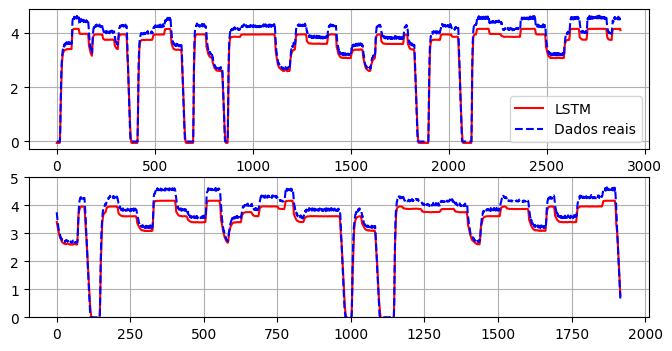

In [37]:
plt.figure(0, figsize=(8,4))
plt.subplot(211)
plt.plot(Yp_train[0:],'r-',label='LSTM')
plt.plot(Y_train[0:],'b--',label='Dados reais')
plt.legend(loc="lower right")
plt.grid()

plt.subplot(212)
plt.plot(Yp_val[0:],'r-',label='LSTM')
plt.plot(Y_val[0:],'b--',label='Dados reais')
plt.ylim((0,5))
plt.grid()
plt.show()

In [38]:
from sklearn.metrics import r2_score as AjusteR2

print('AJuste de treinamento = ', AjusteR2(Yp_train,Y_train))
print('AJuste de validação = ', AjusteR2(Yp_val,Y_val))

AJuste de treinamento =  0.9368037965619045
AJuste de validação =  0.9292158860655017


In [39]:
DadosTreino.history

{'loss': [0.1548779308795929, 0.0729009285569191],
 'r2_score': [0.8962087631225586, 0.9511452317237854],
 'val_loss': [0.023957325145602226, 0.06776873767375946],
 'val_r2_score': [0.9791474938392639, 0.9410138726234436]}

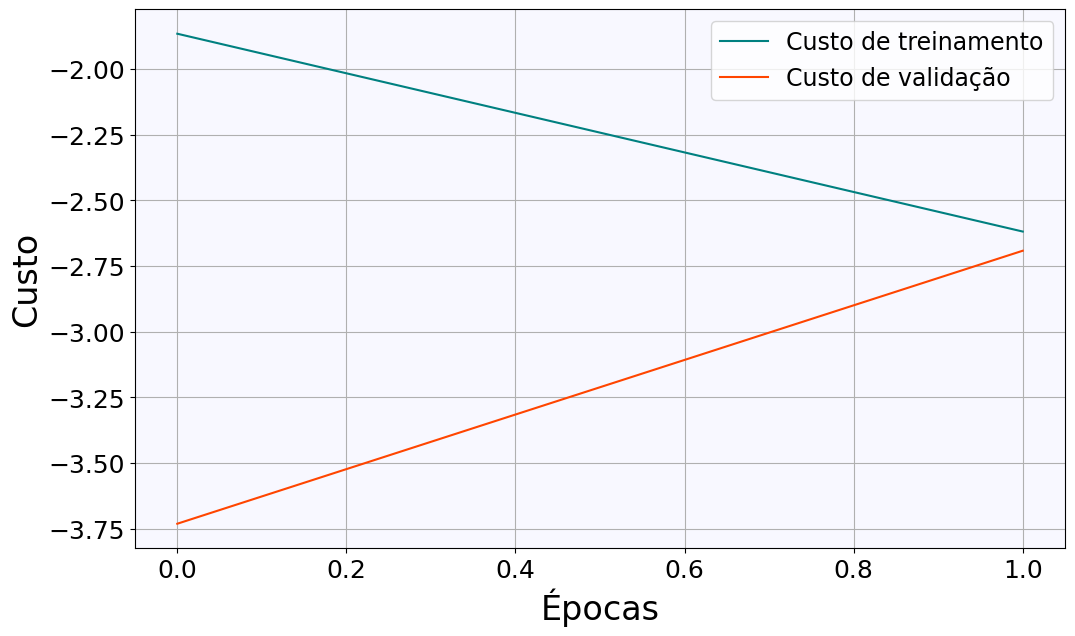

In [52]:
#@title **Loss e Val Loss**
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

loss = DadosTreino.history['loss']
val_loss = DadosTreino.history['val_loss']

cor_trein = "Teal"
cor_valid = "OrangeRed"
esp_linha = 1.5
fundo='GhostWhite'

# Criando o gráfico principal
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(np.log(loss), cor_trein, linewidth=esp_linha)
ax.plot(np.log(val_loss), cor_valid, linewidth=esp_linha)
# ax.set_ylim(-8.3,-4)
ax.set_ylabel("Custo", loc='center', fontsize='24')
ax.set_xlabel('Épocas', loc='center', fontsize='24')
ax.tick_params(labelsize=18)
ax.grid()
ax.legend(["Custo de treinamento", "Custo de validação"], fontsize='17')
ax.set_facecolor(fundo)

plt.show()

In [ ]:
# #@title **Ajuste (ok)**

# import numpy as np
# import matplotlib.pyplot as plt

# N_horas = 10
# ajuste1 = np.zeros(N_horas)
# ajuste2 = np.zeros(N_horas)
# ajuste3 = np.zeros(N_horas)

# # Assuming R2 function is defined elsewhere
# # You may need to import it or define it

# for n in np.arange(0, N_horas):
#     ajuste1[n] = 100 * R2(y_teste1[:,n], yp1[:,n])
#     ajuste2[n] = 100 * R2(y_teste1[:,n], yp2[:,n])
#     ajuste3[n] = 100 * R2(y_teste1[:,n], yp3[:,n])

# plt.figure(figsize=(12, 6))

# # plt.subplot(311)
# # plt.title('Modelo 1')
# plt.plot(ajuste1, label='Modelo LSTM $\mathcal{H}_1$')
# for i, txt in enumerate(ajuste3):
#     plt.text(i, ajuste3[i], '{:.2f}'.format(txt), color ='Black',ha='center', va='bottom', fontsize = '16')
# plt.plot(ajuste2, label='Modelo LSTM $\mathcal{H}_2$')
# plt.plot(ajuste3, label='Modelo LSTM $\mathcal{H}_3$')
# plt.plot(ajuste3, 'xr')
# plt.ylim((97, 100.4))
# plt.xticks(np.arange(10), np.arange(1, 11))
# plt.grid()
# plt.tick_params(labelsize=18)
# plt.ylabel('Ajuste por $R^2$ (%)',fontsize ='24')
# plt.xlabel('Amostra (h)',fontsize ='24')
# plt.legend(fontsize ='21')
# # plt.savefig('ajuste.jpg')
# plt.show()

# # x
# # y Ajuste por R2 (%)